# Music Discovery AI Agent

In [1]:
# TO DO
# put all keys as Colab keys in notebooks instead
# Make sure SQL queries are also defined by the LLMs so that they don't need to be hard coded.
# But give them different information about which tables that might be interesting to look at for each.
# Allow to search the API in Last.fm for similar artists when asking for recommendations.

## Setup and installation

In [1]:
# CELL 1: MINIMAL SETUP
!pip install langgraph requests
!pip install langchain-community langchain-core
!pip install -U langchain-huggingface # remove if not needed?
!pip install transformers torch

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # There should be a better way to do this without clicking
from google.colab import userdata

Mounted at /content/drive


## Configuration and imports

In [2]:
# CELL 2: CONFIGURATION AND IMPORTS
import os
import sqlite3
import requests
import json
import re
import sys
from typing import TypedDict, List, Dict, Any, Tuple
from langgraph.graph import StateGraph, END
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output, Image, display

# Set up paths
DRIVE_PATH = "/content/drive/MyDrive/Colab-Notebooks/last-fm-data"
DATA_PATH = os.path.join(DRIVE_PATH, "data")
DB_PATH = os.path.join(DATA_PATH, "lastfm_data.db")

# IMPORTANT: Add to sys.path BEFORE importing
# Python can't find the utils directory if the path isn't in sys.path
sys.path.append(DRIVE_PATH)

# Import config
try:
    from config.config import LASTFM_API_KEY, USERNAME
    print(f"Config loaded - User: {USERNAME}")
    lastfm_api_key = LASTFM_API_KEY
except ImportError:
    print("No config found")
    lastfm_api_key = None

# Create directories and test database
os.makedirs(DATA_PATH, exist_ok=True)
print(f"Database: {os.path.exists(DB_PATH)}")

Config loaded - User: emmenru
Database: True


## Init Helpers for LLMs:

In [3]:
# CELL 3: INITIALIZE HELPERS
# Move this to the top
from utils.music_discovery_helper import (
    AgentState, DatabaseManager, create_music_agent, test_agent
)

# Initialize database and test connection
db_manager = DatabaseManager(DB_PATH)

# Test database connection
try:
    test_results = db_manager.execute_query("SELECT COUNT(*) as count FROM artists LIMIT 1")
    if test_results:
        print(f"Database connected - Found {test_results[0]['count']} artists")
    else:
        print("Database connected but no artists found")
except Exception as e:
    print(f"Database connection failed: {e}")

Database connected - Found 659 artists


### New: LangGraph Workflow Creation
Hugging face LLM is used to automatically generate SQL queries.



In [4]:
# CELL 4: CREATE STATEFUL MUSIC AGENT
from utils.music_discovery_helper import create_music_agent

# Create a persistent agent that remembers context
agent = create_music_agent(DB_PATH)

print("🎵 Stateful Music Discovery Agent Ready!")

# Simple interface function for notebook use
def ask_music_agent(question):
    """Simple interface to query the music agent"""
    result = agent.process_query(question)
    print(f"🎵 {result['response']}")
    print(f"[Intent: {result['intent']}, Results: {len(result['results'])}]")
    return result

# Test the agent
test_queries = [
    "Recommend some relaxing music",
    "Tell me about Radiohead",
    "Show me my top 10 artists",
    "Recommend some relaxing music",  # This should use cache!
]

print("\n🧪 Testing the agent:")
for query in test_queries:
    print(f"\nTesting: {query}")
    ask_music_agent(query)

# Show session statistics
print(f"\n📊 Session Statistics:")
stats = agent.get_session_stats()
print(f"  Total queries: {stats['total_queries']}")
print(f"  Cache stats: {stats['sql_cache_stats']}")
print(f"  Intent distribution: {stats['intent_distribution']}")

Loading models...


Device set to use cpu
Device set to use cpu


✅ Models loaded successfully
🎵 Stateful Music Discovery Agent Ready!

🧪 Testing the agent:

Testing: Recommend some relaxing music
  🔍 Message: 'Recommend some relaxing music'
  🔍 Label 1: 'recommend new music for me to discover' (score: 0.786)
  🔍 Label 2: 'tell me biographical information about a specific artist or band' (score: 0.128)
  🔍 Label 3: 'show me MY personal listening statistics and data' (score: 0.087)
🎵 I recommend these artists: Radiohead (1,026,970,136 plays), Billie Eilish (641,218,168 plays), Charli xcx (512,531,791 plays)
[Intent: recommend_music, Results: 5]

Testing: Tell me about Radiohead
  🔍 Message: 'Tell me about Radiohead'
  🔍 Label 1: 'tell me biographical information about a specific artist or band' (score: 0.679)
  🔍 Label 2: 'recommend new music for me to discover' (score: 0.314)
  🔍 Label 3: 'show me MY personal listening statistics and data' (score: 0.007)
🎵 I found Radiohead with 1,026,970,136 plays in your music library!
[Intent: artist_info, Results

In [7]:
# Ask questions
#ask_music_agent("Find me some electronic music")

# Check what the agent learned
#stats = agent.get_session_stats()
#print(f"Your preferences: {stats['user_preferences']}")

# Clear the session if needed
#agent.clear_session()

## Visualization

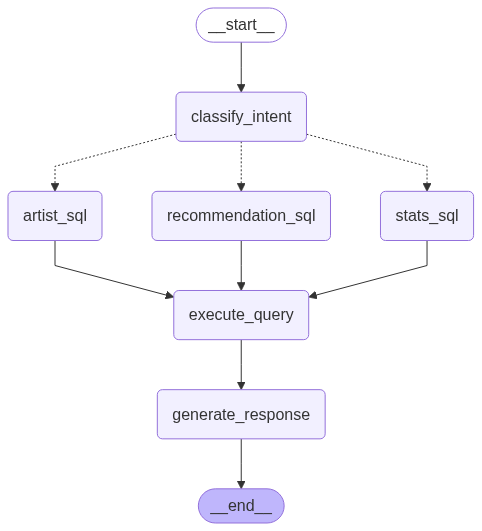

In [5]:
try:
    display(Image(agent.graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## Interface

In [5]:
# TO DO